In [3]:
from src import util as util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from pathlib import Path
import csv

In [4]:
def load_spam_dataset_csv(csv_path):

    messages = []
    labels = []

    with open(csv_path, 'r', newline='', encoding='utf8') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')

        for message, label in reader:
            messages.append(message)
            labels.append(1 if label == '1' else 0)

    return messages, np.array(labels)

In [5]:
train_messages, train_labels = util.load_spam_dataset('data/train.tsv')
test_messages, test_labels = util.load_spam_dataset('data/test.tsv')
train2_messages, train2_labels = load_spam_dataset_csv('data/emails_new_train.csv')
val_messages, val_labels = util.load_spam_dataset('data/val.tsv')

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from typing import Optional, Union
from pathlib import Path

def detect_encoding(file_path: str) -> str:
    """Detect file encoding using chardet"""
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

def show_message_distributions(
    file_path: Union[str, Path],
    text_col: str = 'text',
    label_col: str = 'spam',
    label_mapping: Optional[dict] = None,
    positive_class: str = 'Spam',
    negative_class: str = 'Ham'
) -> None:
    """
    Display professional visualizations for message classification distributions.
    
    Args:
        file_path: Path to CSV/TSV file containing message data
        text_col: Name of column containing message text
        label_col: Name of column containing labels
        label_mapping: Optional dictionary to map raw labels to display names
        positive_class: Name to use for positive class in visualizations
        negative_class: Name to use for negative class in visualizations
    """
    # Determine file type and set separator
    file_path = Path(file_path)
    if file_path.suffix.lower() == '.tsv':
        sep = '\t'
    else:  # default to CSV
        sep = ','
    
    # Load data with encoding detection
    try:
        try:
            data = pd.read_csv(file_path, sep=sep)
        except UnicodeDecodeError:
            encoding = detect_encoding(file_path)
            data = pd.read_csv(file_path, sep=sep, encoding=encoding)
    except Exception as e:
        print(f"Failed to read file: {e}")
        print(f"Supported formats: CSV (.csv) or TSV (.tsv)")
        return

    # Validate columns
    if label_col not in data.columns:
        print(f"Error: Column '{label_col}' not found in data")
        print(f"Available columns: {list(data.columns)}")
        return
    if text_col not in data.columns:
        print(f"Error: Column '{text_col}' not found in data")
        print(f"Available columns: {list(data.columns)}")
        return

    # Standardize labels
    unique_labels = data[label_col].unique()
    
    # Auto-detect label mapping if not provided
    if label_mapping is None:
        if set(map(str, unique_labels)) <= {'0', '1'}:
            label_mapping = {'0': negative_class, '1': positive_class}
        elif set(map(str.lower, map(str, unique_labels))) <= {'ham', 'spam', 'negative', 'positive'}:
            label_mapping = {
                'ham': negative_class, 'spam': positive_class,
                'negative': negative_class, 'positive': positive_class
            }
    
    if label_mapping:
        # Map labels to standardized names
        data['_plot_label'] = data[label_col].astype(str).map(label_mapping)
        data['_numeric_label'] = data[label_col].astype(str).map(
            {k: i for i, k in enumerate(label_mapping)}
        )
    else:
        # Use raw labels if no mapping provided
        data['_plot_label'] = data[label_col].astype(str)
        data['_numeric_label'] = pd.factorize(data[label_col])[0]
    
    # Filter valid data
    valid_data = data.dropna(subset=['_plot_label', '_numeric_label'])
    if len(valid_data) == 0:
        print("Error: No valid labels found after conversion")
        return

    # Set professional style
    sns.set_theme(style="whitegrid")
    plt.style.use('seaborn-v0_8')
    
    # Create figure
    plt.figure(figsize=(14, 6))
    
    # 1. Bar plot - Distribution
    plt.subplot(1, 2, 1)
    ax = sns.countplot(
        x='_numeric_label', 
        hue='_numeric_label',
        data=valid_data, 
        palette="viridis", 
        legend=False
    )
    
    # Get sorted labels
    label_order = valid_data[['_numeric_label', '_plot_label']]\
        .drop_duplicates()\
        .sort_values('_numeric_label')
    xtick_labels = [f"{row['_plot_label']} ({row['_numeric_label']})" 
                   for _, row in label_order.iterrows()]
    
    ax.set_xticks(range(len(label_order)))
    ax.set_xticklabels(xtick_labels)
    plt.title('Message Classification Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Message Type')
    plt.ylabel('Count')
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():,}', 
            (p.get_x() + p.get_width()/2, p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 7), 
            textcoords='offset points',
            fontsize=10,
            fontweight='bold'
        )

    # 2. Pie chart - Proportion
    plt.subplot(1, 2, 2)
    counts = valid_data['_plot_label'].value_counts()
    
    # Use standard colors for binary case, otherwise viridis
    if len(counts) == 2:
        colors = ['#66b3ff', '#ff9999']  # Blue for negative, Red for positive
    else:
        colors = sns.color_palette("viridis", len(counts))
    
    plt.pie(
        counts,
        labels=counts.index,
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*sum(counts)):,})',
        colors=colors,
        startangle=90,
        explode=[0.05]*len(counts),
        shadow=True,
        textprops={'fontsize': 10, 'fontweight': 'bold'},
        wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'}
    )
    
    plt.title('Message Classification Proportion', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


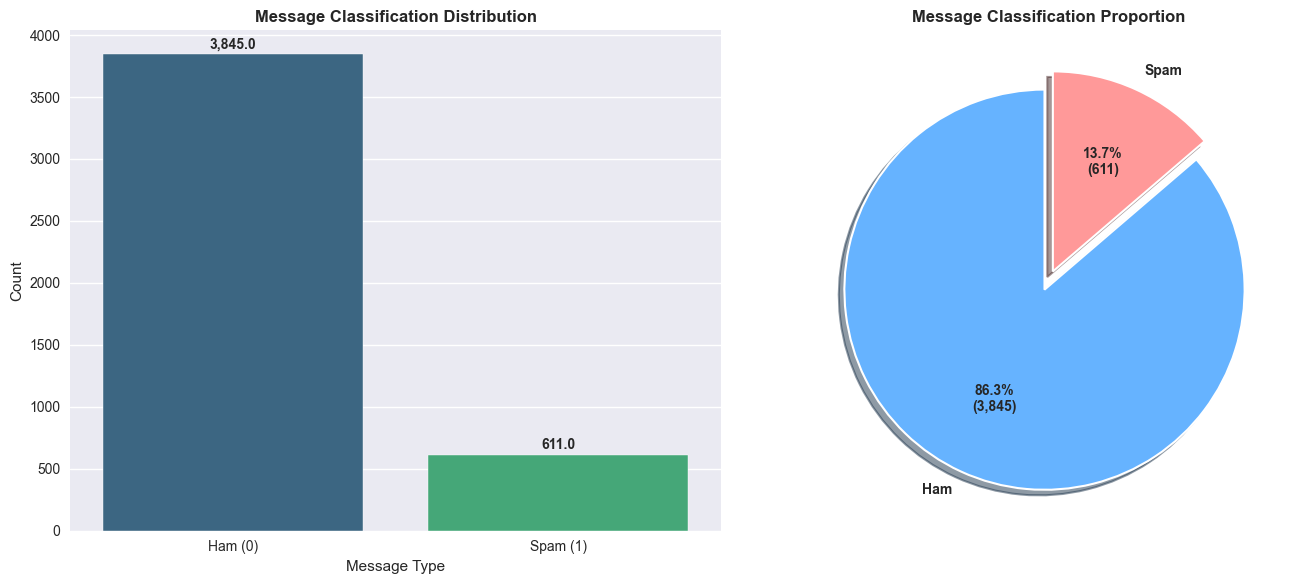

In [7]:
show_message_distributions("data/train.tsv",'THANX 4 PUTTIN DA FONE DOWN ON ME!!','ham')

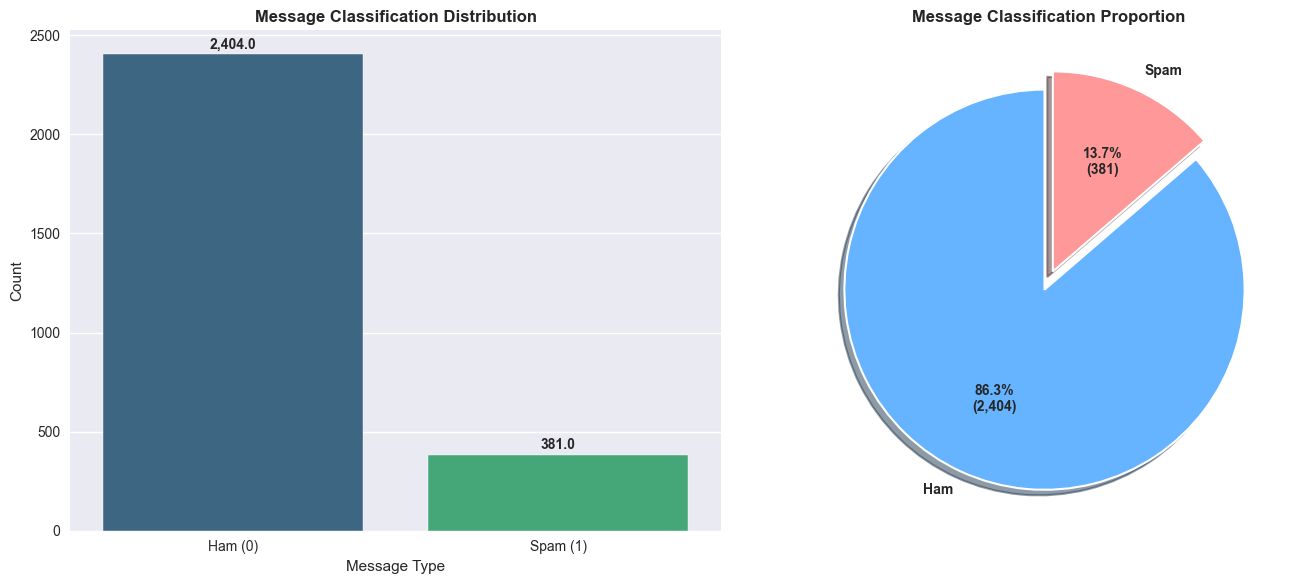

In [10]:
show_message_distributions("data/spam.csv","v2","v1")

In [36]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm

# Initialize BERT (CPU-only)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Disable dropout for inference

def get_bert_embeddings(email_bodies, batch_size=4):
    """Convert emails to BERT embeddings using PyTorch"""
    all_embeddings = []
    
    for i in tqdm(range(0, len(email_bodies), batch_size), 
                 desc="Processing emails"):
        batch_emails = email_bodies[i:i + batch_size]
        
        inputs = tokenizer(
            batch_emails,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Use [CLS] token embedding as sentence representation
        cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        all_embeddings.extend(cls_embeddings)
    
    return np.vstack(all_embeddings)

In [37]:
embeddings = get_bert_embeddings(train_messages)
print(f"Generated embeddings shape: {embeddings.shape}")
print(f"First email embedding (first 5 dims): {embeddings[0][:5]}")

Processing emails: 100%|███████████████████████████████████████████████████████████| 1115/1115 [06:04<00:00,  3.06it/s]


Generated embeddings shape: (4457, 768)
First email embedding (first 5 dims): [-0.1019436   0.04453429  0.06067634 -0.05734915 -0.46334663]


In [38]:
def getwords(message):
    return message.lower().split()

In [39]:
def h(theta,x):
    return 1 / (1 + np.exp(-np.dot(x, theta)))

In [11]:
def Create_dictionary(messages):
    words = [word for message in messages for word in getwords(message)]
    words_count = collections.Counter(words)
    #word_dic = {(word, count) for word,count in words_count.items() if count>=5}
    freq_word = [word for word,count in words_count.items() if count>=10 and word !='subject:']
    return {word: count for count, word in enumerate(freq_word)}

In [12]:
dicWords = Create_dictionary(train_messages)

In [13]:
def Transform_text(messages, word_dictionary):
    m = len(messages)
    n = len(word_dictionary)
    matrix = np.zeros((m,n), dtype=int)

    word_counts = [collections.Counter(getwords(message)) for message in messages]
    for i in range(m):
        for word, count in word_counts[i].items():
            if word in word_dictionary:
                matrix[i][word_dictionary[word]] += count

    return matrix


In [14]:
train_matrix = Transform_text(train_messages,dicWords)

In [15]:
train_matrix.shape

(4457, 877)

In [16]:
X_with_bias = np.c_[np.ones(embeddings.shape[0]),embeddings]

In [17]:
class LogisticRegressionWithGD:
    def __init__(self,alpha=0.1,iteration=1000):
        self.alpha = alpha
        self.iteration=iteration
        self.theta=None
    def h(self,theta, x):
        return 1 / (1 + np.exp(-np.dot(x, theta)))
    def fit(self,x,y):
        lambda_ = 1
        n,m = x.shape
        X_with_bias = np.c_[np.ones(n),x]
        self.theta = np.zeros(m+1)
        #Gradient
        for i in range(self.iteration):
            #With regularization
            linearmodel = (np.dot(X_with_bias.T, (self.h(self.theta, X_with_bias)-y))/m)
            L1_reg = np.sign(self.theta)*lambda_

            L2_reg = lambda_*self.theta
            linearmodel += L2_reg
            self.theta = self.theta - self.alpha*linearmodel
        
        
    def predict(self,x):
        X_with_bias = np.c_[np.ones(x.shape[0]),x]
        y_predicted = 1/(1+np.exp(-X_with_bias.dot(self.theta)))
        y_result = [1 if i>0.5 else 0 for i in y_predicted]
        return y_result

In [18]:
LR = LogisticRegressionWithGD(alpha=0.01,iteration=1000)
LR.fit(embeddings,train_labels)
LR_predictions = LR.predict(embeddings)

In [19]:
embeddings_testing = get_bert_embeddings(test_messages)

Processing emails: 100%|█████████████████████████████████████████████████████████████| 140/140 [00:28<00:00,  4.94it/s]


In [20]:
LR_predictions_testing = LR.predict(embeddings_testing)

In [21]:
LR_accuracy = np.mean(LR_predictions_testing == test_labels)

In [22]:
print('SimpLe Logistic Regression had an accuracy of {} on the testing set'.format(LR_accuracy))

SimpLe Logistic Regression had an accuracy of 0.974910394265233 on the testing set


In [23]:
len(embeddings_testing)

558

In [24]:
test_messages_simple = [
    # Non-Spam (Ham) - 15 examples
    "Hi John, just checking in to see if you're still on for lunch tomorrow at 12:30 PM.",
    "The quarterly financial report has been uploaded to the shared drive for your review.",
    "Team meeting reminder: Wednesday at 3 PM in Conference Room A. Agenda attached.",
    "Your Amazon order #12345 has shipped and will arrive on Friday.",
    "Thanks for your application! We'll review your resume and get back to you next week.",
    "The software update has been completed successfully on all servers.",
    "Mom: Don't forget we're having family dinner this Sunday at 6 PM.",
    "Your monthly bank statement is now available in your online banking portal.",
    "The project deadline has been extended to March 15th per client request.",
    "Password reset confirmation: Your password was changed successfully.",
    "Doctor's appointment reminder: You have a checkup scheduled for May 3rd at 10 AM.",
    "Your subscription to Tech Magazine has been renewed automatically.",
    "The attached document contains the meeting minutes from yesterday's call.",
    "Your flight LAX to JFK is confirmed for departure at 8:45 AM tomorrow.",
    "HR Notification: Please complete your benefits enrollment by Friday.",

    # Spam - 5 examples
    "URGENT: Your account will be suspended unless you verify your details now!",
    "CONGRATULATIONS! You've won a free iPhone - click here to claim your prize!",
    "Make $10,000 a week from home with this simple trick! No experience needed!",
    "Your package couldn't be delivered - click this link to reschedule immediately!",
    "Limited time offer! Act now to get 90% off - this deal expires in 1 hour!"
]

matrix_15_5 = get_bert_embeddings(test_messages_simple)

Processing emails: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


In [25]:
LR_predictions_testing_sss = LR.predict(matrix_15_5)

In [26]:
LR_predictions_testing_sss

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [27]:
len(train2_messages)

10907

In [28]:
text = 'BERT feature extraction transforms natural language processing'

In [29]:
get_bert_embeddings(text)

Processing emails: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.92it/s]


array([[-0.23314503,  0.28411537,  0.05699809, ...,  0.09551524,
         0.29385418,  0.08826991],
       [-0.29589862,  0.01453173, -0.1582289 , ..., -0.03710428,
         0.0316409 ,  0.4605663 ],
       [-0.33579275,  0.14855966, -0.16715094, ..., -0.3852319 ,
         0.29932642,  0.20627055],
       ...,
       [-0.45344138, -0.2255309 , -0.24701905, ...,  0.03556406,
         0.10428005,  0.46626   ],
       [-0.2317295 ,  0.13488227,  0.02399457, ..., -0.07811093,
         0.06078478,  0.3404302 ],
       [-0.5327432 , -0.097869  , -0.13282384, ..., -0.20946157,
         0.2529567 ,  0.10044993]], dtype=float32)

use Large dataset

In [88]:
matrix_large_embeddings = get_bert_embeddings(train2_messages)

Processing emails: 100%|███████████████████████████████████████████████████████████| 2727/2727 [38:39<00:00,  1.18it/s]


In [30]:
from sklearn.linear_model import LogisticRegression

In [89]:
len(train2_messages)

10907

In [93]:
matrix_large_embeddings.shape

(10907, 768)

In [101]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(kernel='linear', class_weight='balanced')  

# Train
svm.fit(matrix_large_embeddings, train2_labels)


SVC(class_weight='balanced', kernel='linear')

In [99]:
matrix_test_embeddings = get_bert_embeddings(test_messages)

Processing emails: 100%|█████████████████████████████████████████████████████████████| 140/140 [00:25<00:00,  5.42it/s]


In [95]:
LR_predictions_te = log_reg.predict(matrix_test_embeddings)

In [102]:

y_pred = svm.predict(matrix_test_embeddings)
print("Accuracy:", accuracy_score(test_labels, y_pred))

Accuracy: 0.38530465949820786


In [96]:
LR_accuracy_large = np.mean(LR_predictions_te == test_labels)

In [97]:
print('SimpLe Logistic Regression had an accuracy of {} on the testing set'.format(LR_accuracy_large))

SimpLe Logistic Regression had an accuracy of 0.4265232974910394 on the testing set


In [109]:
simpletesting=[
"Don't forget to Subscribe our page in www.hh.com",
    
'Get new phone free Click this URL',
"Urgent your Account has been compromised. Verify your details now",
    "Making $5000 a week working from home. No Skills required",
"Your Package delivery failed. Click here to reschedule",
    "Act now this offer expires in 24 hours",
    "Get rich quick with this one simple trick",
    "Warning ",
    "Hi Team,Just a reminder that we have our weekly project sync tomorrow at 10:00 AM EST in Conference Room B. Please bring your updates on the Q2 deliverables."

]

In [110]:
ee = get_bert_embeddings(simpletesting)

Processing emails: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


In [111]:
simple_svm = svm.predict(ee)

In [112]:
simple_svm

array([1, 1, 1, 1, 1, 1, 1, 1, 0])

In [116]:
test_messages_simple = [
    # Non-Spam (Ham) - 15 examples
    "Hi John, just checking in to see if you're still on for lunch tomorrow at 12:30 PM.",
    "The quarterly financial report has been uploaded to the shared drive for your review.",
    "Team meeting reminder: Wednesday at 3 PM in Conference Room A. Agenda attached.",
    "Your Amazon order #12345 has shipped and will arrive on Friday.",
    "Thanks for your application! We'll review your resume and get back to you next week.",
    "The software update has been completed successfully on all servers.",
    "Mom: Don't forget we're having family dinner this Sunday at 6 PM.",
    "Your monthly bank statement is now available in your online banking portal.",
    "The project deadline has been extended to March 15th per client request.",
    "Password reset confirmation: Your password was changed successfully.",
    "Doctor's appointment reminder: You have a checkup scheduled for May 3rd at 10 AM.",
    "Your subscription to Tech Magazine has been renewed automatically.",
    "The attached document contains the meeting minutes from yesterday's call.",
    "Your flight LAX to JFK is confirmed for departure at 8:45 AM tomorrow.",
    "HR Notification: Please complete your benefits enrollment by Friday.",

    # Spam - 5 examples
    "URGENT: Your account will be suspended unless you verify your details now!",
    "CONGRATULATIONS! You've won a free iPhone - click here to claim your prize!",
    "Make $10,000 a week from home with this simple trick! No experience needed!",
    "Your package couldn't be delivered - click this link to reschedule immediately!",
    "Limited time offer! Act now to get 90% off - this deal expires in 1 hour!"
]

matrix_15_5 = get_bert_embeddings(test_messages_simple)

Processing emails: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


In [117]:
simple_svm_2 = svm.predict(matrix_15_5)

In [118]:
simple_svm_2

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1])

In [123]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV
# 2. Optimized SVM Pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Critical for SVM
    ('svm', SVC(
        kernel='rbf',              # Better for complex patterns
        class_weight='balanced',
        probability=True,          # Enable predict_proba
        cache_size=1000,           # For large datasets
        random_state=42
    ))
])

# 3. Hyperparameter Tuning (Reduced search space for efficiency)
param_dist = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01]
}

search = RandomizedSearchCV(
    svm_pipeline,
    param_dist,
    n_iter=10,                    # Reduced for faster tuning
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

In [125]:

search.fit(matrix_large_embeddings, train2_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm',
                                              SVC(cache_size=1000,
                                                  class_weight='balanced',
                                                  probability=True,
                                                  random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'svm__C': [0.1, 1, 10, 100],
                                        'svm__gamma': ['scale', 'auto', 0.001,
                                                       0.01]},
                   scoring='f1_weighted')

In [132]:
simple_svm_3 = search.predict(matrix_15_5)
simple_svm_3

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [133]:
simple_svm_4 = search.predict(matrix_test_embeddings)

In [134]:
LR_accuracy_large_4 = np.mean(simple_svm_4 == test_labels)
print('SimpLe Logistic Regression had an accuracy of {} on the testing set'.format(LR_accuracy_large_4))

SimpLe Logistic Regression had an accuracy of 0.48566308243727596 on the testing set
